In [1]:
import nltk
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import re

In [2]:
import tensorflow as tf

### Load and clean data

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("filipkin/steam-reviews")

print("Path to dataset files:", path)

100%|██████████| 13.9M/13.9M [00:01<00:00, 8.47MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/filipkin/steam-reviews/versions/6


In [4]:
# load dataset
df = pd.read_csv(f"{path}/output.csv")

In [5]:
df.shape

(201151, 5)

In [6]:
df.head()

,id,app_id,content,author_id,is_positive
0,181331361,100,At least its a counter strike -1/100,76561199556485100,Negative
1,180872601,100,Uh... So far my playthrough has not been great...,76561199230620391,Negative
2,177836246,100,Better mechanics than cs2,76561198417690647,Negative
3,177287444,100,buggy mess and NOT fun to play at all,76561199077268730,Negative
4,176678990,100,"Whoever came up with this, is gonna fucking ge...",76561199104544266,Negative


#### Data Preparation & Cleaning

In [7]:
# Clean text

# drop id columns
df = df.drop(['author_id', 'app_id', 'id'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201151 entries, 0 to 201150
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   content      200723 non-null  object
 1   is_positive  201151 non-null  object
dtypes: object(2)
memory usage: 3.1+ MB


In [8]:
# Handle missing/incorrect data
df = df.dropna()
df.isnull().sum()

,0
content,0
is_positive,0


In [9]:
# cleaning content
import unicodedata

def clean_text(text):
    text = str(text)
    text = unicodedata.normalize("NFKD", text) # normalize unicode
    text = text.replace('\n', ' ').replace('\r', ' ')
    text = text.lower() # lower case text
    text = re.sub(r"http\S+", " ", text) # remove URLs
    text = text.replace('"', ' ').replace("'", " ") # remove leftover quotes
    text = re.sub(r"[^a-zA-ZÀ-ÿ0-9\s.,!?]", " ", text) # remove extra characters
    text = re.sub(r"\s+", " ", text).strip() # remove extra spaces
    return text

In [10]:
df['clean_content'] = df['content'].apply(clean_text)
df = df[df['clean_content'].str.count(r'[a-zA-Z]') > 5]
df = df.reset_index(drop=True)

In [11]:
# Remove punctuations
df['clean_no_punct'] = df['clean_content'].apply(lambda x: re.sub(r'[^a-zA-ZÀ-ÿ0-9\s]', ' ', x))

In [12]:
# tokenize clean_no_punct

df['tokens'] = df['clean_no_punct'].str.split()

In [13]:
# Add features

# char_count: number of characters in content

df['char_count'] = df['content'].str.len()

In [14]:
# word_count: number of words in content
df['word_count'] = df['content'].str.split().str.len()

In [15]:
# avg_word_length: average length of words in content
df['avg_word_length'] = df['clean_content'].apply(lambda x: np.mean([len(word) for word in x.split()]))

In [16]:
df.head()

,content,is_positive,clean_content,clean_no_punct,tokens,char_count,word_count,avg_word_length
0,At least its a counter strike -1/100,Negative,at least its a counter strike 1 100,at least its a counter strike 1 100,"[at, least, its, a, counter, strike, 1, 100]",36,7,3.500000
1,Uh... So far my playthrough has not been great...,Negative,uh... so far my playthrough has not been great...,uh so far my playthrough has not been great...,"[uh, so, far, my, playthrough, has, not, been,...",230,42,4.476190
2,Better mechanics than cs2,Negative,better mechanics than cs2,better mechanics than cs2,"[better, mechanics, than, cs2]",25,4,5.500000
3,buggy mess and NOT fun to play at all,Negative,buggy mess and not fun to play at all,buggy mess and not fun to play at all,"[buggy, mess, and, not, fun, to, play, at, all]",37,9,3.222222
4,"Whoever came up with this, is gonna fucking ge...",Negative,"whoever came up with this, is gonna fucking ge...",whoever came up with this is gonna fucking ge...,"[whoever, came, up, with, this, is, gonna, fuc...",76,14,4.500000


### Word Analysis

In [17]:
# get sentiment scores using VADER
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

df['sentiment_score'] = df['clean_content'].apply(lambda x: sia.polarity_scores(x)['compound'])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [18]:
# convert is_positive into integer values
df['is_positive_int'] = df['is_positive'].map({'Positive': 1, 'Negative': 0})

In [19]:
df.head()

,content,is_positive,clean_content,clean_no_punct,tokens,char_count,word_count,avg_word_length,sentiment_score,is_positive_int
0,At least its a counter strike -1/100,Negative,at least its a counter strike 1 100,at least its a counter strike 1 100,"[at, least, its, a, counter, strike, 1, 100]",36,7,3.500000,-0.1280,0
1,Uh... So far my playthrough has not been great...,Negative,uh... so far my playthrough has not been great...,uh so far my playthrough has not been great...,"[uh, so, far, my, playthrough, has, not, been,...",230,42,4.476190,-0.8357,0
2,Better mechanics than cs2,Negative,better mechanics than cs2,better mechanics than cs2,"[better, mechanics, than, cs2]",25,4,5.500000,0.4404,0
3,buggy mess and NOT fun to play at all,Negative,buggy mess and not fun to play at all,buggy mess and not fun to play at all,"[buggy, mess, and, not, fun, to, play, at, all]",37,9,3.222222,-0.7382,0
4,"Whoever came up with this, is gonna fucking ge...",Negative,"whoever came up with this, is gonna fucking ge...",whoever came up with this is gonna fucking ge...,"[whoever, came, up, with, this, is, gonna, fuc...",76,14,4.500000,-0.7269,0


### Classical Machine Learning

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

X = df['clean_content']
y = df['is_positive_int']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



======================== Logistic Regression ========================
Accuracy: 0.8579
              precision    recall  f1-score   support

           0       0.87      0.84      0.85     17280
           1       0.85      0.88      0.86     17694

    accuracy                           0.86     34974
   macro avg       0.86      0.86      0.86     34974
weighted avg       0.86      0.86      0.86     34974



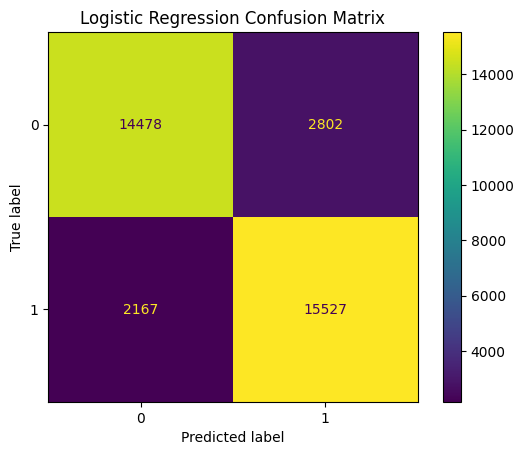

In [21]:
# Logistic Regression
log_reg = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
acc = accuracy_score(y_test, y_pred_lr)
print("\n======================== Logistic Regression ========================")
print(f"Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred_lr))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr)
plt.title("Logistic Regression Confusion Matrix")
plt.show()


======================== LinearSVC ========================
Accuracy: 0.8559
              precision    recall  f1-score   support

           0       0.87      0.84      0.85     17280
           1       0.85      0.87      0.86     17694

    accuracy                           0.86     34974
   macro avg       0.86      0.86      0.86     34974
weighted avg       0.86      0.86      0.86     34974



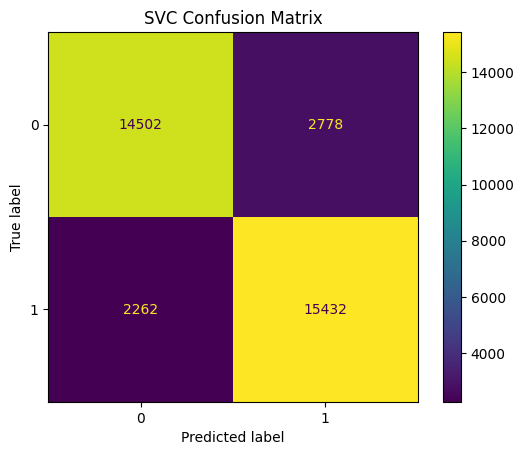

In [22]:
# Support Vector Machine
svc = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC())
])

svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
acc = accuracy_score(y_test, y_pred_svc)
print("\n======================== LinearSVC ========================")
print(f"Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred_svc))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svc)
plt.title("SVC Confusion Matrix")
plt.show()


======================== Multinomial Naive Bayes ========================
Accuracy: 0.8423
              precision    recall  f1-score   support

           0       0.85      0.83      0.84     17280
           1       0.84      0.85      0.85     17694

    accuracy                           0.84     34974
   macro avg       0.84      0.84      0.84     34974
weighted avg       0.84      0.84      0.84     34974



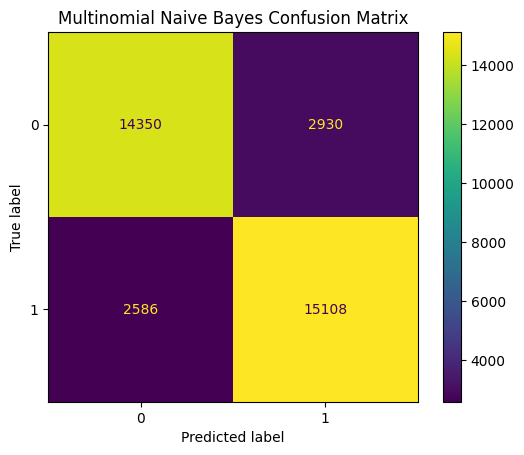

In [23]:
# Multinomial Naive Bayes
mnb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

mnb.fit(X_train, y_train)
y_pred_mnb = mnb.predict(X_test)
acc = accuracy_score(y_test, y_pred_mnb)
print("\n======================== Multinomial Naive Bayes ========================")
print(f"Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred_mnb))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mnb)
plt.title("Multinomial Naive Bayes Confusion Matrix")
plt.show()

### Deep Learning

LSTM

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

In [25]:
# split data
X = df['clean_content'].astype(str).values
y = df['is_positive_int'].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [26]:
# Tokenizing & padding
vocab_size = 20000 # max number of words to keep
max_len = 200 # max tokens per review

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=max_len, padding='post', truncating='post')

In [29]:
# DNN Classifier (multi-class classification)

embedding_dim = 100

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(256, return_sequences=False)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [30]:
# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [31]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Train model
history = model.fit(
    X_train_pad,
    y_train,
    epochs=5,
    batch_size=256,
    verbose=1
)

Epoch 1/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 65s 100ms/step - accuracy: 0.7617 - loss: 0.5098
Epoch 2/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 57s 104ms/step - accuracy: 0.8755 - loss: 0.3009
Epoch 3/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 56s 102ms/step - accuracy: 0.8905 - loss: 0.2666
Epoch 4/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 56s 102ms/step - accuracy: 0.9071 - loss: 0.2341
Epoch 5/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 56s 102ms/step - accuracy: 0.9150 - loss: 0.2139


1093/1093 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step
Test accuracy: 0.8666723852004347
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     17280
           1       0.87      0.87      0.87     17694

    accuracy                           0.87     34974
   macro avg       0.87      0.87      0.87     34974
weighted avg       0.87      0.87      0.87     34974



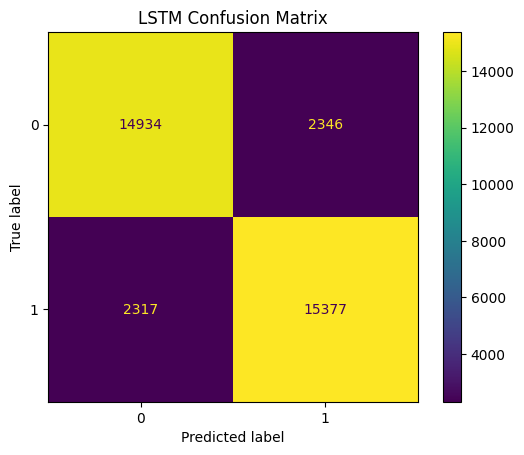

In [33]:
# Evaluate model
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

print("Test accuracy:", (y_pred == y_test).mean())
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("LSTM Confusion Matrix")
plt.show()